[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/biodatlab/deep-learning-skooldio/blob/master/03_handwritten_recognition_explore.ipynb)

## **Thai-digit handwritten classification with Pytorch: Student Notebook Exploration**

This notebook contains exploration of the "Thai-digit handwritten classification" including
- Customizing model
    - Adding layers
    - Adding dropout layer
- Adding image augmentation

## **Download and clean the dataset from the repository**

- We have downloaded the data from https://github.com/kittinan/thai-handwriting-number by cloning the repository
- Remove files that have character mismatch (as suggested by the the creator)
- Then, we put the cleaned data at https://github.com/biodatlab/deep-learning-skooldio

In [1]:
!git clone https://github.com/biodatlab/deep-learning-skooldio

Cloning into 'deep-learning-skooldio'...
remote: Enumerating objects: 1990, done.
remote: Counting objects: 100% (284/284), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 1990 (delta 153), reused 233 (delta 120), pack-reused 1706
Receiving objects: 100% (1990/1990), 14.75 MiB | 29.32 MiB/s, done.
Resolving deltas: 100% (164/164), done.


After cloning the repository, check that `deep-learning-skooldio` should appear in the directory.

In [2]:
import os
import os.path as op
from glob import glob
from pathlib import Path
import random
from PIL import Image
from collections import Counter
from torch.utils.data import ConcatDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
directory = "deep-learning-skooldio/"
paths = glob(op.join(directory, "thai-handwritten-dataset", "*", "*"))
num_samples = len(paths)
print("Number of samples", num_samples)

Number of samples 1750


In [4]:
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import shutil

train_paths, test_paths = train_test_split(paths, test_size=0.1, random_state=42)
for i in range(10):
    os.makedirs(f"data/train/{i}", exist_ok=True)
    os.makedirs(f"data/validation/{i}", exist_ok=True)

In [5]:
def copy_to_destination(src_paths, dst_path: str = "data/train/"):
    for path in tqdm(src_paths):
        path = Path(path)
        parent_dir = path.parent.name
        shutil.copy(path, op.join(dst_path, parent_dir, path.name))

In [6]:
copy_to_destination(train_paths, "data/train/")
copy_to_destination(test_paths, "data/validation/")

  0%|          | 0/1575 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

In [7]:
len(glob("data/train/*/*")), len(glob("data/validation/*/*"))

(1575, 175)

## **Create a custom dataset and a dataloader**

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [10]:
class ThaiDigitDataset(Dataset):
    def __init__(self, img_dir: str, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = [(p, Path(p).parent.name) for p in glob(op.join(img_dir, "*", "*"))]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image, label = self.img_labels[idx]
        label = int(label)
        image = Image.open(image)
        if self.transform:
            image = 1 - self.transform(image)
        return image, label

In [11]:
train_thaidigit_dataset = ThaiDigitDataset("data/train/", transform=transform)
val_thaidigit_dataset = ThaiDigitDataset("data/validation/", transform=transform)

In [12]:
train_loader = DataLoader(train_thaidigit_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_thaidigit_dataset, batch_size=16, shuffle=False)

## **Create the model**

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class ThaiDigitNet(nn.Module):
    def __init__(self):
        super(ThaiDigitNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

## **Train the model**

In [14]:
# Create training loop function
def train(model, n_epochs, loss_function, optimizer, train_loader, validation_loader):
    training_logs = {"train_loss": [],  "train_acc": [], "val_loss": [], "val_acc": []}
    print("-"*80)
    for epoch in range(1, n_epochs+1):
        # training
        model.train()
        train_loss, correct = 0, 0
        for images, labels in train_loader:
            pred = model(images)
            loss = loss_function(pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct += (pred.argmax(1) == labels).float().sum().item()
        # save training logs
        training_logs["train_loss"].append(train_loss/ len(train_loader))
        training_logs["train_acc"].append(correct / len(train_loader.dataset))

        # validation
        model.eval()
        val_loss, correct = 0, 0
        for images, labels in validation_loader:
            pred = model(images)
            val_loss += loss_function(pred, labels).item()
            correct += (pred.argmax(1) == labels).float().sum().item()
        # save validation logs
        training_logs["val_loss"].append(val_loss/ len(val_loader))
        training_logs["val_acc"].append(correct / len(validation_loader.dataset))

        print(f"Epochs {epoch}".ljust(10), 
              f"train loss {training_logs['train_loss'][-1]:.5f}",
              f"train acc {training_logs['train_acc'][-1]:.5f}",

              f"val loss {training_logs['val_loss'][-1]:.5f}",
              f"val acc {training_logs['val_acc'][-1]:.5f}",
              )
        print("-"*80)
    return model, training_logs
        

In [18]:
n_epoch = 100

net = ThaiDigitNet() # Initialize the model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
net, net_history = train(net, n_epoch, loss_fn, optimizer, train_loader, val_loader)

--------------------------------------------------------------------------------
Epochs 1   train loss 2.29104 train acc 0.11048 val loss 2.27734 val acc 0.15429
--------------------------------------------------------------------------------
Epochs 2   train loss 2.25231 train acc 0.21524 val loss 2.23748 val acc 0.25143
--------------------------------------------------------------------------------
Epochs 3   train loss 2.20640 train acc 0.27111 val loss 2.18769 val acc 0.30857
--------------------------------------------------------------------------------
Epochs 4   train loss 2.15121 train acc 0.28825 val loss 2.12486 val acc 0.39429
--------------------------------------------------------------------------------
Epochs 5   train loss 2.08295 train acc 0.37397 val loss 2.05143 val acc 0.42857
--------------------------------------------------------------------------------
Epochs 6   train loss 2.00475 train acc 0.40635 val loss 1.96576 val acc 0.45714
----------------------------

In [19]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["val_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["val_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

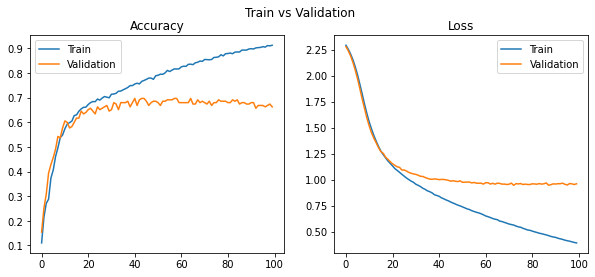

In [20]:
plot_graph(net_history)

We can observe "overfitting" as the model learns to predict the training set well but perform worse in validation set

## **Evaluate the model**

In [21]:
# Create evaluation function for the model
def evaluate(val_dir, model):
    model.eval()
    paths = glob(op.join(val_dir, "*", "*"))
    predictions = []
    for idx, path in enumerate(paths):
        img = 1 - transform(Image.open(path))
        pred = model(img)
        predictions.append({
            "path": path,
            "prediction": int(pred.argmax(dim=1).item()),
            "label": int(Path(path).parent.name)
        })

    results = pd.DataFrame(predictions)
    # Calculate accuracy
    accuracy = (results.prediction == results.label).sum() / len(results)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return results

In [22]:
pred_df = evaluate("data/validation/", net)
pred_df.head(3)

Accuracy: 66.29%


,path,prediction,label
0,data/validation/8/d86d0ca1-d4cb-48e9-aa8a-6c0f...,8,8
1,data/validation/8/23_6db9fc09-96ed-44a9-8052-c...,8,8
2,data/validation/8/1e7a0e6c-9b02-434c-bf88-6d60...,8,8


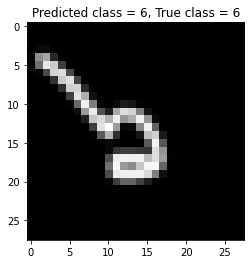

In [23]:
# Show some random images with their predicted number
sample_path = glob("data/validation/*/*.png")[50]
img = Image.open(sample_path)
img = (1 - transform(img)).squeeze(0)
pred = net(img)
pred = int(pred.argmax(dim=1))
true_class = Path(sample_path).parent.name

plt.title("Predicted class = {}, True class = {}".format(pred, true_class))
plt.imshow(img, cmap="gray")
plt.show()

## **Train neural network model with more layers**

In [38]:
# TODO: Create neural network with more layers
class ThaiDigitMoreLayers(nn.Module):
    def __init__(self):
        super(ThaiDigitMoreLayers, self).__init__()
        # TODO: Create layers
        self.fc1 = nn.Linear(28 * 28, 392)
        self.fc2 = nn.Linear(392, 196)
        self.fc3 = nn.Linear(196, 98)
        self.fc4 = nn.Linear(98, 10)
        
    def forward(self, x):
        # TODO: forward pass
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

In [39]:
n_epochs = 100

more_layers_model = ThaiDigitMoreLayers()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(more_layers_model.parameters(), lr=0.01)

more_layers_model, more_layers_model_history = train(
    more_layers_model, n_epochs, loss_fn, optimizer, train_loader, val_loader
)

--------------------------------------------------------------------------------
Epochs 1   train loss 2.30348 train acc 0.10159 val loss 2.30684 val acc 0.08571
--------------------------------------------------------------------------------
Epochs 2   train loss 2.30209 train acc 0.10159 val loss 2.30525 val acc 0.08571
--------------------------------------------------------------------------------
Epochs 3   train loss 2.30018 train acc 0.10159 val loss 2.30365 val acc 0.08571
--------------------------------------------------------------------------------
Epochs 4   train loss 2.29867 train acc 0.10222 val loss 2.30206 val acc 0.09143
--------------------------------------------------------------------------------
Epochs 5   train loss 2.29694 train acc 0.10603 val loss 2.30035 val acc 0.10857
--------------------------------------------------------------------------------
Epochs 6   train loss 2.29484 train acc 0.13587 val loss 2.29861 val acc 0.12571
----------------------------

In [40]:
pred_df = evaluate("data/validation/", more_layers_model)
pred_df.head(3)

Accuracy: 73.14%


,path,prediction,label
0,data/validation/8/d86d0ca1-d4cb-48e9-aa8a-6c0f...,8,8
1,data/validation/8/23_6db9fc09-96ed-44a9-8052-c...,8,8
2,data/validation/8/1e7a0e6c-9b02-434c-bf88-6d60...,8,8


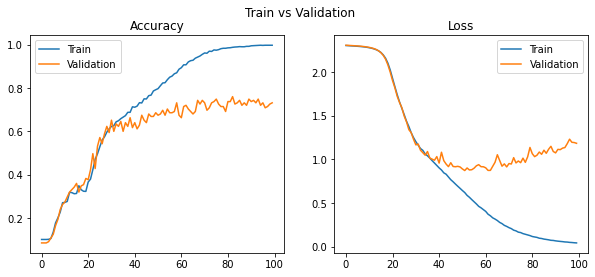

In [41]:
plot_graph(more_layers_model_history)

The training accuracy of the model is higher than the validation accuracy.
This means that the model is overfitting the training data.
We can try to reduce the overfitting by adding regularization .

## **Regularization with Dropout**

Dropout is one of the techniques used to prevent overfitting. Here, we can train the model for more epochs to observe the loss curve.

In [42]:
# TODO: Add Dropout layer to the previous neural network
class DropoutThaiDigit(nn.Module):
    def __init__(self):
        super(DropoutThaiDigit, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 392)
        self.fc2 = nn.Linear(392, 196)
        self.fc3 = nn.Linear(196, 98)
        self.fc4 = nn.Linear(98, 10)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        # TODO: forward pass
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [44]:
n_epochs = 100
drop_model = DropoutThaiDigit()  # Initialize a model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(drop_model.parameters(), lr=0.01)

dropout_model, dropout_model_history = train(drop_model, n_epochs, loss_fn, optimizer, train_loader, val_loader)

--------------------------------------------------------------------------------
Epochs 1   train loss 2.30427 train acc 0.10222 val loss 2.30502 val acc 0.12000
--------------------------------------------------------------------------------
Epochs 2   train loss 2.30317 train acc 0.10032 val loss 2.30416 val acc 0.12000
--------------------------------------------------------------------------------
Epochs 3   train loss 2.30139 train acc 0.11556 val loss 2.30305 val acc 0.14857
--------------------------------------------------------------------------------
Epochs 4   train loss 2.30017 train acc 0.15429 val loss 2.30209 val acc 0.18286
--------------------------------------------------------------------------------
Epochs 5   train loss 2.29853 train acc 0.15937 val loss 2.30089 val acc 0.22857
--------------------------------------------------------------------------------
Epochs 6   train loss 2.29704 train acc 0.16508 val loss 2.29940 val acc 0.15429
----------------------------

In [49]:
pred_df = evaluate("data/validation/", dropout_model)
pred_df.head(3)

Accuracy: 73.71%


,path,prediction,label
0,data/validation/8/d86d0ca1-d4cb-48e9-aa8a-6c0f...,8,8
1,data/validation/8/23_6db9fc09-96ed-44a9-8052-c...,8,8
2,data/validation/8/1e7a0e6c-9b02-434c-bf88-6d60...,8,8


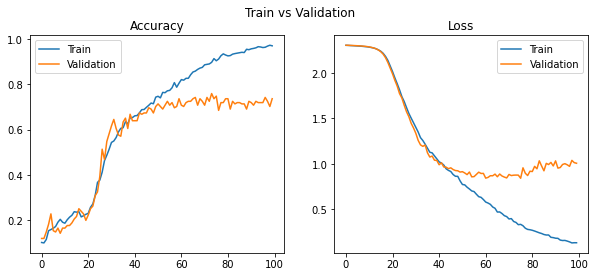

In [50]:
plot_graph(dropout_model_history)

Now the gap between the training accuracy and validation accuracy is smaller than before.

## **Image Augmentation**

Image augmentation is a technique used to artificially increase the size of a training dataset by creating modified versions of existing images.

In [56]:
# TODO: Add image augmentation in `train_transform`

train_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    # add RandomAffine here
    transforms.RandomAffine(degrees=(-10, 10), translate=(0.0, 0.1), scale=(1, 1)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

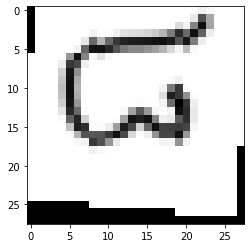

In [58]:
path = glob("deep-learning-skooldio/thai-handwritten-dataset/*/*")[30]
img = Image.open(path)

# TODO: Transform image using `train_transform`
transformed_img = train_transform(img).squeeze(0)

plt.imshow(transformed_img, cmap="gray")
plt.show()

In [61]:
train_thaidigit_dataset = ThaiDigitDataset("data/train/", transform=train_transform)
val_thaidigit_dataset = ThaiDigitDataset("data/validation/", transform=val_transform)

In [62]:
train_dataloader = DataLoader(train_thaidigit_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_thaidigit_dataset, batch_size=16, shuffle=False)

In [63]:
# Let's train the model with augmented data
n_epochs = 150
augmented_model = DropoutThaiDigit()  # Initialize the model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(augmented_model.parameters(), lr=0.01)

augmented_model, augmented_model_history = train(
    augmented_model, n_epochs, loss_fn, optimizer, train_dataloader, val_dataloader
)

--------------------------------------------------------------------------------
Epochs 1   train loss 2.30356 train acc 0.10667 val loss 2.30306 val acc 0.10857
--------------------------------------------------------------------------------
Epochs 2   train loss 2.30207 train acc 0.10984 val loss 2.30252 val acc 0.10286
--------------------------------------------------------------------------------
Epochs 3   train loss 2.30086 train acc 0.11492 val loss 2.30200 val acc 0.13143
--------------------------------------------------------------------------------
Epochs 4   train loss 2.30005 train acc 0.13206 val loss 2.30142 val acc 0.10857
--------------------------------------------------------------------------------
Epochs 5   train loss 2.29875 train acc 0.11746 val loss 2.30062 val acc 0.12000
--------------------------------------------------------------------------------
Epochs 6   train loss 2.29730 train acc 0.12063 val loss 2.29975 val acc 0.13143
----------------------------

In [64]:
# Evaluate the new model with old dataset.
pred_df = evaluate("data/validation/", augmented_model)
pred_df.head(3)

Accuracy: 78.86%


,path,prediction,label
0,data/validation/8/d86d0ca1-d4cb-48e9-aa8a-6c0f...,8,8
1,data/validation/8/23_6db9fc09-96ed-44a9-8052-c...,8,8
2,data/validation/8/1e7a0e6c-9b02-434c-bf88-6d60...,8,8


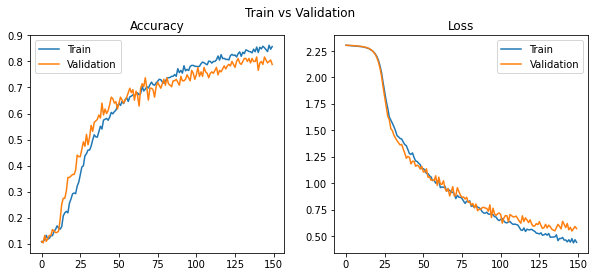

In [65]:
plot_graph(augmented_model_history)

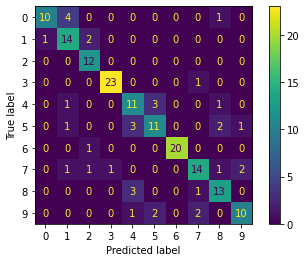

In [66]:
# Confusion matrix
cm = confusion_matrix(pred_df.label, pred_df.prediction, labels=range(10))
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
display.plot()
plt.show()